In [1]:
# Import necessary libraries. In case of an error don't continue running the rest of the cells
# To avoid errors create the environment with the following command on Anaconda prompt: 
# conda create --name <YOUR_ENVIRONMENT_NAME> --file requirements.txt
# Make sure to run the command on the folder .../Miniscope-v4-Wire-Free/Python DAQ Interface

import numpy as np
import numpy.polynomial.polynomial as poly
from matplotlib import pyplot as plt
import cv2
import time
import pandas as pd

In [2]:
driveName = r"\\.\PhysicalDrive2"  # Change this to the correct drive
videoFileName = "Federico" + time.strftime("_%Y%m%d-%H%M%S") # Video name will be [videoFileName][timestamp].avi

# Read Data Sectors
saveVideo = True
plotHeaderValues = True
displayVideo = False
TargetFPS = 20

In [3]:
# SD Card sector information
headerSector =          1022 # Holds user settings to configure Miniscope and recording
configSector =          1023 # Holds final settings of the actual recording
dataStartSector =       1024 # Recording data starts here
sectorSize =            512

WRITE_KEY0 =				0x0D7CBA17
WRITE_KEY1 =				0x0D7CBA17
WRITE_KEY2 =				0x0D7CBA17
WRITE_KEY3 =				0x0D7CBA17

# SD Card Header Sector positions
HEADER_GAIN_POS =				4
HEADER_LED_POS =				5
HEADER_EWL_POS =				6
HEADER_RECORD_LENGTH_POS =  	7
HEADER_FRAME_RATE = 			8

# SD Card Config Sector positions
CONFIG_BLOCK_WIDTH_POS =			    0
CONFIG_BLOCK_HEIGHT_POS	=   		    1
CONFIG_BLOCK_FRAME_RATE_POS	=   	    2
CONFIG_BLOCK_BUFFER_SIZE_POS =  	    3
CONFIG_BLOCK_NUM_BUFFERS_RECORDED_POS =	4
CONFIG_BLOCK_NUM_BUFFERS_DROPPED_POS =	5

# Data Buffer Header positions
BUFFER_HEADER_HEADER_LENGTH_POS =			0
BUFFER_HEADER_LINKED_LIST_POS = 			1
BUFFER_HEADER_FRAME_NUM_POS	=   			2
BUFFER_HEADER_BUFFER_COUNT_POS =			3
BUFFER_HEADER_FRAME_BUFFER_COUNT_POS =  	4
BUFFER_HEADER_WRITE_BUFFER_COUNT_POS =  	5
BUFFER_HEADER_DROPPED_BUFFER_COUNT_POS =	6
BUFFER_HEADER_TIMESTAMP_POS	=   			7
BUFFER_HEADER_DATA_LENGTH_POS = 			8
BUFFER_HEADER_WRITE_TIMESTAMP_POS = 		9
BUFFER_HEADER_BATTERY_POS=				   10
BUFFER_HEADER_EWL_POS=					11

In [4]:
# Needs to be run as administrator to have access to openning and reading card

# variables that you can adjust
correctDrive = False
f = open(driveName, "rb+")  # Open drive

# Make sure this is the correct drive
# Read SD Card header and config sectors
f.seek(headerSector * sectorSize, 0)  # Move to correct sector
headerSectorData = np.frombuffer(f.read(sectorSize), dtype=np.uint32)
if (True):
#if ((WRITE_KEY0 == headerSectorData[0]) and (WRITE_KEY1 == headerSectorData[1]) and (WRITE_KEY2 == headerSectorData[2]) and (WRITE_KEY3 == headerSectorData[3])):
    correctDrive = True
    print("SD Card Opened.")
else:
    print ("Wrong Drive.")
    correctDrive = False
    f.close()

SD Card Opened.


In [5]:
# Do not normally need to run this cell
    
#f.close()

In [6]:
# Load up Config Sector

f.seek(configSector * sectorSize, 0)  # Move to correct sector
configSectorData = np.frombuffer(f.read(sectorSize), dtype=np.uint32)



# This needs to be removed once WF Miniscope writes this sector correctly
# configSectorData[CONFIG_BLOCK_WIDTH_POS] = 304
# configSectorData[CONFIG_BLOCK_HEIGHT_POS] = 304
# configSectorData[CONFIG_BLOCK_NUM_BUFFERS_RECORDED_POS] = 290
configSectorData

array([  304,   304,    20, 20480,  4588,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]


----------
Video saved as: Federico_20240305-17141820240305-171421.avi


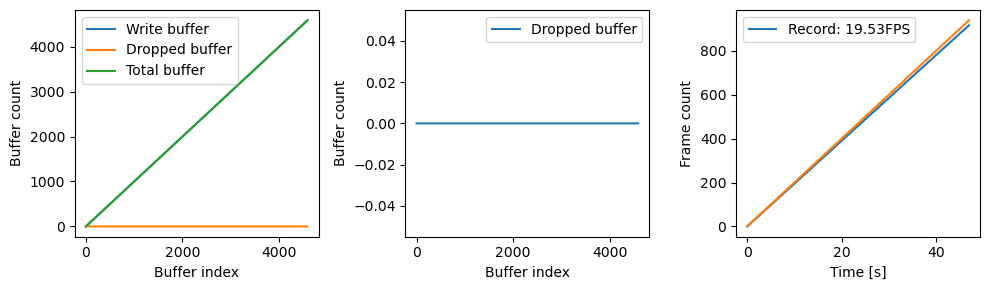

In [7]:
frameNum = 0
pixelCount = 0
header = []

if saveVideo is True:
    out = cv2.VideoWriter(videoFileName + '.avi', cv2.VideoWriter_fourcc(*'GREY'), 
                        10.0, (configSectorData[CONFIG_BLOCK_WIDTH_POS], configSectorData[CONFIG_BLOCK_HEIGHT_POS] ), 
                        isColor=False)

frame = np.zeros((configSectorData[CONFIG_BLOCK_WIDTH_POS] * configSectorData[CONFIG_BLOCK_HEIGHT_POS], 1), dtype=np.uint8)
f.seek(dataStartSector * sectorSize, 0) # Starting data location
for i in range(configSectorData[CONFIG_BLOCK_NUM_BUFFERS_RECORDED_POS]):
    dataHeader = np.frombuffer(f.read(4), dtype=np.uint32) # gets header length
    dataHeader = np.append(dataHeader, np.frombuffer(f.read((dataHeader[BUFFER_HEADER_HEADER_LENGTH_POS] - 1) * 4), dtype=np.uint32))

    header.append(dataHeader)
    
    numBlocks = int((dataHeader[BUFFER_HEADER_DATA_LENGTH_POS] + (dataHeader[BUFFER_HEADER_HEADER_LENGTH_POS] * 4) + (512 - 1)) / 512)
    
    data = np.frombuffer(f.read(numBlocks*512 - dataHeader[BUFFER_HEADER_HEADER_LENGTH_POS] * 4), dtype=np.uint8)

    # Calculate buffer per frame at every start of a frame
    if (dataHeader[BUFFER_HEADER_FRAME_BUFFER_COUNT_POS] == 0):
        bufferPerFrame = int(np.ceil(configSectorData[CONFIG_BLOCK_WIDTH_POS] * configSectorData[CONFIG_BLOCK_HEIGHT_POS] / dataHeader[BUFFER_HEADER_DATA_LENGTH_POS]))

    # -------------------------------------
    if (dataHeader[BUFFER_HEADER_FRAME_BUFFER_COUNT_POS]%bufferPerFrame == 0):
        # First buffer of a frame
        
        if saveVideo is True:
            out.write(np.reshape(frame, (configSectorData[CONFIG_BLOCK_WIDTH_POS], configSectorData[CONFIG_BLOCK_HEIGHT_POS] )))
        
        if displayVideo is True:
            cv2.imshow('Video', np.reshape(frame, (configSectorData[CONFIG_BLOCK_WIDTH_POS], configSectorData[CONFIG_BLOCK_HEIGHT_POS] )))
            cv2.waitKey(20)
        
        if len(data) <= dataHeader[BUFFER_HEADER_DATA_LENGTH_POS]:
            frame[0:dataHeader[BUFFER_HEADER_DATA_LENGTH_POS], 0] = data
        else:
            frame[0:len(data), 0] = data
            print('----------\n[Data overflow]\nFrame count: ' + str(dataHeader[BUFFER_HEADER_FRAME_NUM_POS]) +
                '\nFrame buffer count: ' + str(dataHeader[BUFFER_HEADER_FRAME_BUFFER_COUNT_POS]) +
                '\nData length (Metadata): ' + str(dataHeader[BUFFER_HEADER_DATA_LENGTH_POS]) +
                '\nData length (Actual): ' + str(len(data)) +
                '\nData header: ' + str(dataHeader))

        pixelCount = dataHeader[BUFFER_HEADER_DATA_LENGTH_POS]
        frameNum = dataHeader[BUFFER_HEADER_FRAME_NUM_POS]
    else:
        # All other buffers of a frame
        # startIdx = dataHeader[BUFFER_HEADER_FRAME_BUFFER_COUNT_POS] * 50 * 512
        emptyPixelCount = len(frame[pixelCount:(pixelCount + dataHeader[BUFFER_HEADER_DATA_LENGTH_POS]), 0])

        if emptyPixelCount >= len(data[:dataHeader[BUFFER_HEADER_DATA_LENGTH_POS]]):
            frame[pixelCount:(pixelCount + dataHeader[BUFFER_HEADER_DATA_LENGTH_POS]), 0] = data[:dataHeader[BUFFER_HEADER_DATA_LENGTH_POS]]
            pixelCount = pixelCount + dataHeader[BUFFER_HEADER_DATA_LENGTH_POS]
        else:
            frame[pixelCount:(pixelCount + dataHeader[BUFFER_HEADER_DATA_LENGTH_POS]), 0] = data[:emptyPixelCount]
            pixelCount = pixelCount + dataHeader[BUFFER_HEADER_DATA_LENGTH_POS]
            print('----------\n[Pixel overflow]\nFrame count: ' + str(dataHeader[BUFFER_HEADER_FRAME_NUM_POS]) +
                '\nFrame buffer count: ' + str(dataHeader[BUFFER_HEADER_FRAME_BUFFER_COUNT_POS]) +
                '\nData length: ' + str(dataHeader[BUFFER_HEADER_DATA_LENGTH_POS]) +
                '\nPixel count: ' + str(pixelCount) +
                '\nData header: ' + str(dataHeader))

if saveVideo is True:            
    out.release()
    print('\n----------\nVideo saved as: ' + videoFileName + time.strftime("%Y%m%d-%H%M%S") + '.avi')

if displayVideo is True:
    cv2.destroyWindow('Video')
    
if plotHeaderValues is True:
    # plot succeeded buffers
    fig, ax = plt.subplots(1, 3)

    ax[0].plot([headerline[BUFFER_HEADER_WRITE_BUFFER_COUNT_POS] for headerline in header], label='Write buffer')
    ax[0].plot([headerline[BUFFER_HEADER_DROPPED_BUFFER_COUNT_POS] for headerline in header], label='Dropped buffer')
    ax[0].plot([headerline[BUFFER_HEADER_BUFFER_COUNT_POS] for headerline in header], label='Total buffer')
    ax[0].legend()
    ax[0].set_xlabel("Buffer index")
    ax[0].set_ylabel("Buffer count")

    # plot dropped buffers
    ax[1].plot([headerline[BUFFER_HEADER_DROPPED_BUFFER_COUNT_POS] for headerline in header], label='Dropped buffer')
    ax[1].legend()
    ax[1].set_xlabel("Buffer index")
    ax[1].set_ylabel("Buffer count")

    # plot timestamp and FPS
    frameindex = []
    frametimestamp = []
    EWLtimestamp = []

    for i in range(len(header)):
        if header[i][BUFFER_HEADER_FRAME_BUFFER_COUNT_POS] == 0:
            frameindex.append(header[i][BUFFER_HEADER_FRAME_NUM_POS])
            frametimestamp.append(header[i][BUFFER_HEADER_TIMESTAMP_POS]/1000) # convert to ms
            EWLtimestamp.append(header[i][BUFFER_HEADER_EWL_POS])

    coefs = poly.polyfit(frametimestamp, frameindex, 1)

    ax[2].plot(frametimestamp, frameindex, label='Record: '+str('{:.2f}'.format(coefs[1]))+'FPS')
    ax[2].set_xlabel('Time [s]')
    ax[2].set_ylabel('Frame count')
    ax[2].legend()
    ax[2].plot(frametimestamp, [i * TargetFPS for i in frametimestamp], label=str(TargetFPS) + 'FPS')

    fig.set_figheight(3)
    fig.set_figwidth(10)

    fig.tight_layout()
    plt.show()

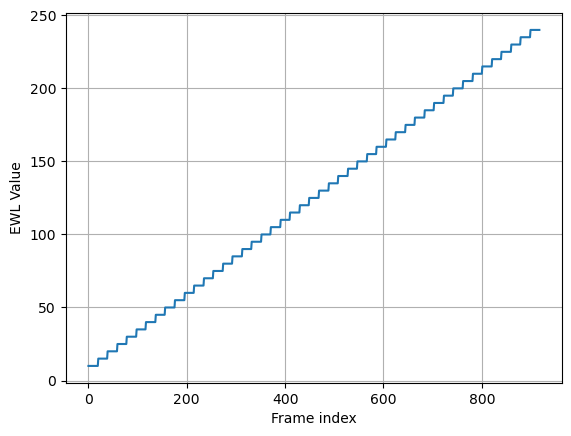

In [8]:
plt.plot(frameindex,EWLtimestamp)
plt.xlabel('Frame index')
plt.ylabel('EWL Value')
plt.grid()

In [9]:
columns_name = ["Header length","Linked List position",'Frame#','Buffer_Count','Frame Buffer count','Write Buffer count',
                'Dropped buffer count','Timestamp','Data length','Timestamp Write','Battery ADC','EWL']
headerData = pd.DataFrame(header, columns = columns_name)

In [10]:
csv_data = headerData.to_csv()
with open(videoFileName + '.csv', 'w') as csv_file:
    headerData.to_csv(path_or_buf=csv_file,index=False, lineterminator='\n')

In [11]:
get_rows = headerData.head(40)
print(get_rows)

    Header length  Linked List position  Frame#  Buffer_Count  \
0              12                     0       0             0   
1              12                     1       0             1   
2              12                     2       0             2   
3              12                     3       0             3   
4              12                     4       0             4   
5              12                     5       1             5   
6              12                     6       1             6   
7              12                     7       1             7   
8              12                     0       1             8   
9              12                     1       1             9   
10             12                     2       2            10   
11             12                     3       2            11   
12             12                     4       2            12   
13             12                     5       2            13   
14             12        

In [12]:
dataHeader

array([   12,     3,   917,  4587,     2,  4587,     0, 47000, 20432,
       47000,   165,   240], dtype=uint32)